## Predicting INTEL share price with LSTM (Long Short Term Memory) in Keras

Sequence prediction problems have been around for a long time. They are considered as one of the hardest problems to solve in the data science industry. These include a wide range of problems; from predicting sales to finding patterns in stock markets’ data, from understanding movie plots to recognizing your way of speech, from language translations to predicting your next word on your iPhone’s keyboard.

With the recent breakthroughs that have been happening in data science, it is found that for almost all of these sequence prediction problems, Long short Term Memory networks, a.k.a LSTMs have been observed as the most effective solution.

LSTMs have an edge over conventional feed-forward neural networks and RNN in many ways. This is because of their property of selectively remembering patterns for long durations of time. 

##### LSTM imrovement over RNN

 Let’s take the example of predicting stock prices for a particular stock. The stock price of today will depend upon:

The trend that the stock has been following in the previous days, maybe a downtrend or an uptrend.
The price of the stock on the previous day, because many traders compare the stock’s previous day price before buying it.
The factors that can affect the price of the stock for today. This can be a new company policy that is being criticized widely, or a drop in the company’s profit, or maybe an unexpected change in the senior leadership of the company.


#### LSTM with Keras

In [1]:
#importing all necessary libraries

import pandas as pd
import numpy as np

# for reproducibility of our results
np.random.seed(1234)

from datetime import date
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [2]:
# pre-set the plot font sizes...

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

#### Helper functions:
##### Mean Absolute Percentage Error (MAPE)
    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    mape - Mean Absolute Percentage Error (%)


##### Root Mean Squared Error (RMSE)

    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    rmse - Root Mean Squared Error

In [3]:
def calc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


def calc_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.power((y_true - y_pred),2)))
    return rmse

#### Load and explore data

In [11]:
#load data
df = pd.read_csv('data/intel_shares.csv')
#quick check of dimensions of loaded file
df.shape

(1090, 13)

In [12]:
#check column data types
df.dtypes

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
Dividend      float64
Split           int64
Adj_Open      float64
Adj_High      float64
Adj_Low       float64
Adj_Close     float64
Adj_Volume      int64
dtype: object

In [13]:
#check top 5
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2017-12-28,46.36,46.36,45.95,46.22,9504372,0.0,1,43.065202,43.065202,42.684341,42.935152,9504372
1,2017-12-27,46.11,46.36,46.00,46.11,13359671,0.0,1,42.832969,43.065202,42.730787,42.832969,13359671
2,2017-12-26,46.28,46.47,45.95,46.08,15533328,0.0,1,42.990887,43.167384,42.684341,42.805101,15533328
3,2017-12-22,46.33,47.02,46.02,46.70,33913537,0.0,1,43.037334,43.678296,42.749366,43.381038,33913537
4,2017-12-21,47.54,47.59,46.56,46.76,42963451,0.0,1,44.161339,44.207786,43.250988,43.436774,42963451


In [14]:
# sumarize numerical features
df.describe()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,1090.000000,1090.000000,1090.000000,1090.000000,1.090000e+03,1090.000000,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1.090000e+03
mean,32.630198,32.914932,32.366546,32.662958,2.751649e+07,0.003856,1.0,28.596575,28.845280,28.365734,28.625122,2.751649e+07
std,4.878730,4.903212,4.834242,4.879762,1.278323e+07,0.030726,0.0,5.142092,5.167886,5.098526,5.143473,1.278323e+07
min,22.210000,22.240000,21.970000,22.067000,5.893789e+06,0.000000,1.0,18.099864,18.124313,17.904278,17.983328,5.893789e+06
25%,29.662500,30.035000,29.452500,29.737500,1.997469e+07,0.000000,1.0,25.672825,25.965026,25.361902,25.759755,1.997469e+07
50%,33.615000,33.950000,33.245000,33.640000,2.456095e+07,0.000000,1.0,28.707943,28.952093,28.482547,28.759941,2.456095e+07
75%,35.590000,35.890000,35.317500,35.597500,3.111780e+07,0.000000,1.0,31.910852,32.159808,31.773663,31.991365,3.111780e+07
max,47.540000,47.640000,46.660000,47.560000,1.358932e+08,0.272500,1.0,44.161339,44.254233,43.343881,44.179918,1.358932e+08


There is no missing value, suspected structural error or suspected outliers in the dataset. Data was collected in a complete form and had been QC'ed.

This is as expected as the dataset is downloaded from Quandl, a company that offers trading dataset to customers.
https://www.quandl.com/

In [15]:
#remove duplicates, if any (suppose no, as data is cleaned)
# Drop duplicates
df = df.drop_duplicates()
print(df.shape)

(1090, 13)


#### data preprocessing and visualization

We are only interested in Date and Close (price shares sold), and nothing else for this analysis and prediction

In [16]:
# convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.head(3)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2017-12-28,46.36,46.36,45.95,46.22,9504372,0.0,1,43.065202,43.065202,42.684341,42.935152,9504372
1,2017-12-27,46.11,46.36,46.00,46.11,13359671,0.0,1,42.832969,43.065202,42.730787,42.832969,13359671
2,2017-12-26,46.28,46.47,45.95,46.08,15533328,0.0,1,42.990887,43.167384,42.684341,42.805101,15533328


In [17]:
#check column data types
df.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Dividend             float64
Split                  int64
Adj_Open             float64
Adj_High             float64
Adj_Low              float64
Adj_Close            float64
Adj_Volume             int64
dtype: object

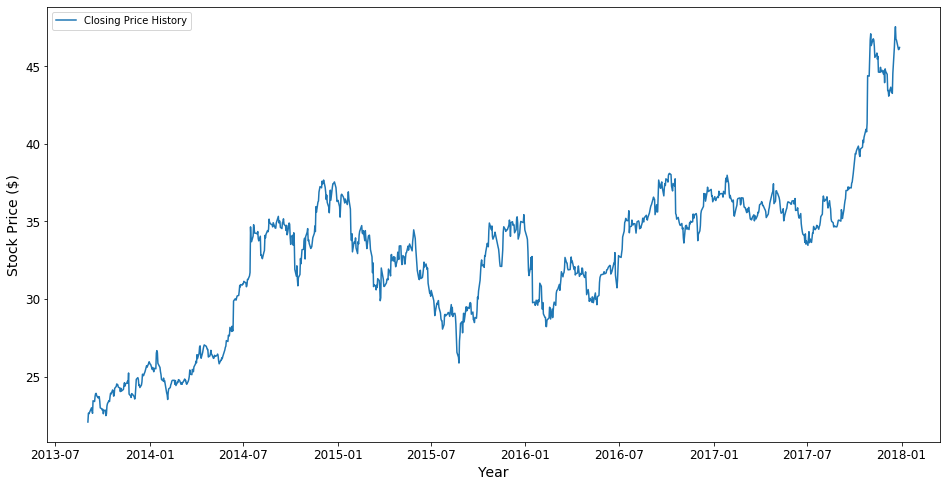

In [18]:
#visualize time series - Date vs Close

#all sizes for annotations specified above,standard for all pictures 

plt.figure(figsize = (16,8))
plt.plot(df['Date'], df['Close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.show()

#### Split data into training and testing data
Before we begin our modelling, we will split our dataset into training and testing data.

For time series forecasting, we cannot use random split to split our data, this is because it will destory the time component of the data. We will set earlier 80% of data to training dataset and remaining 20% data to testing dataset.

In [21]:
# sort by datetime (otherwise all data is in random order, first train data, than test data)
df.sort_values(by='Date', inplace=True, ascending=True)

test_size = 0.2  #20%
training_size = 1 - test_size  #80%

test_num = int(test_size * len(df))
train_num = int(training_size * len(df))

print("train_num: " + str(train_num))
print("test_num: " + str(test_num))



train = df[:train_num][['Date', 'Close']]
test = df[train_num:][['Date', 'Close']]

train_num: 872
test_num: 218


#### Moving Average Algorithm

Moving Average is a simple technical analysis method that smoothens out price values by creating a continuously updating average price. The average price is usually taken over a period of time - it can be 30 minutes, 10 days, 2 weeks, 1 month, or any period an investor chooses.
Moving Average is a popular strategy because it can be adjusted to any timeframe, and so it is suitable for both long-term and short-term investors. It helps to cut down the ‘noise’ on the price chart, thereby allowing investors to get a basic idea of which way the stock price is moving.
The timeframe or length you choose for a moving average (also known as look back period) can have a big impact on how effective it is. A shorter timeframe will react much quicker to price change than a longer time frame, e.g. 20-day moving average tracks more closely on the actual price than 100-day moving average.
To identify significant, long-term support and resistance levels and overall stock price trends, 50-day, 100-day and 200-day timeframes are commonly used. The 200-day timeframe is in fact considered as the most significant in stock trading.

Below is the plot showing the prediction of stock price using testing data size (218) as our Moving Average timeframe. The 218-day timeframe is chosen purely because I want to simplify my codes in Python. For the purpose of this algorithm comparison, you can treat 218-day and 200-day as similar timeframes.


A moving average (MA) is a widely used technical indicator that smooths out price trends by filtering out the “noise” from random short-term price fluctuations.
Moving averages can be constructed in several different ways, and employ different numbers of days for the averaging interval.
The most common applications of moving averages are to identify trend direction and to determine support and resistance levels.
When asset prices cross over their moving averages, it may generate a trading signal for technical traders.
While moving averages are useful enough on their own, they also form the basis for other technical indicators such as the moving average convergence divergence (MACD).

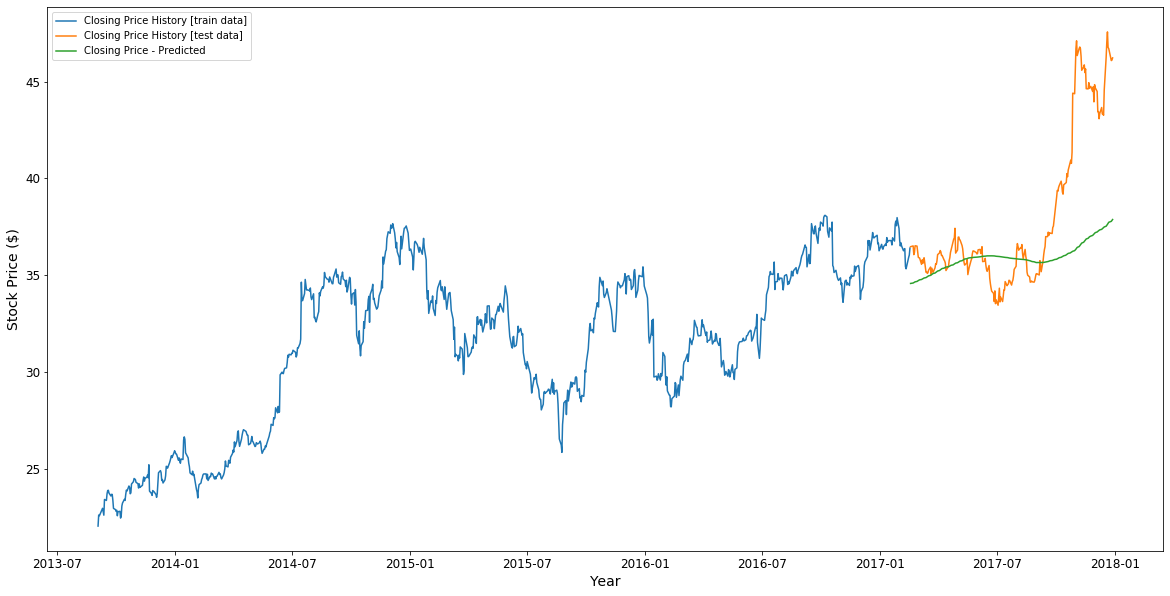

In [22]:
preds = []

#calculate prediction as moving average on test data
for i in range(0, test.shape[0]):
    a = train['Close'][len(train) - test.shape[0] + i:].sum() + test['Close'][:i].sum()
    b = a/test.shape[0]
    preds.append(b)
    
    
# Plot predicted price vs actual closing price 

# moving average -> predictions
test['Predictions_ma'] = preds
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_ma'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

From the plot, you can see the prediction did not go so well. The predicted values are mostly of the same range as historical pricing in the training data for the timeframe we chose.

In [23]:
# Evaluate performance
rmse_ma = calc_rmse(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Root Mean Squared Error: ' + str(rmse_ma))
mape_ma = calc_mape(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Mean Absolute Percentage Error (%): ' + str(mape_ma))

Root Mean Squared Error: 3.9597817916358133
Mean Absolute Percentage Error (%): 6.175502851776837


### LSTM Algorithm
Long Short Term Memory (LSTM)

Standardise all our feature variables to the same scale

Long Short Term Memory (LSTM)
LSTM is a deep learning technique that was developed to overcome the vanishing and exploding gradients when training in traditional Recurrent Neural Network (RNN). The ability of LSTM to take in important information from past and ignore unimportant information, makes it very powerful in predicting future trend, especially in stock price prediction. For a more detailed understanding of LSTM, you can read this article.
For now, let’s treat LSTM as a ‘black box’ and implement it. We will use past 60 days’ stock prices as our input variable and the 61th day’s stock price as our output variable, because I believe 60 days is a sufficient timeframe for the algorithm to learn the price trend.


##### Standardise all our feature variables to the same scale

In [24]:
# scale our dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]

###### Function get_x_y  for data split
If we need to combine last 60 days of stock price for example

In [26]:
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [27]:
# we use past 60 days stock prices for our training to predict 61th day's closing price.
# scaled_data_train - offset value
X_train, y_train = get_x_y(scaled_data_train, 60, 60)

### LSTM Model


In [28]:
# initial LSTM parameters
lstm_units = 50 
optimizer = 'adam' #this parameter should be tested, different optimizers used
epochs = 1  # this parameter should be tested
batch_size = 1 #this parameter should be tested


#model
model = Sequential()
model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = lstm_units))
model.add(Dense(1))

In [29]:
# Compile and fit the LSTM network
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/1
 - 29s - loss: 0.0031


In [30]:
# predict stock prices using past 60 stock prices
inputs = df['Close'][len(df) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

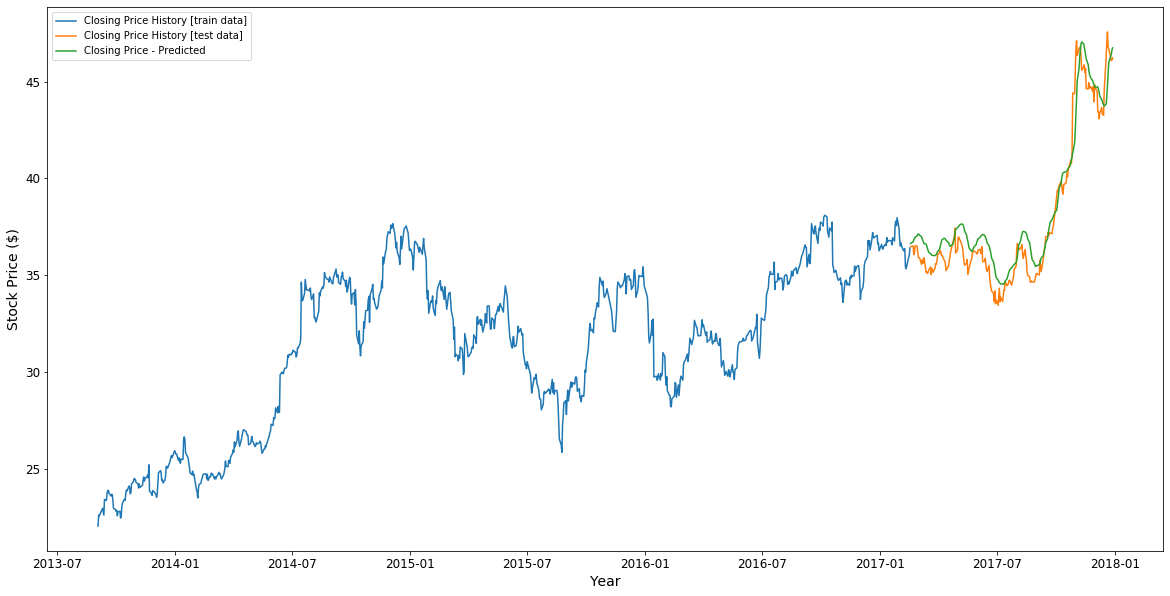

In [31]:
# Plot predicted price vs actual closing price 

test['Predictions_lstm'] = closing_price
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_lstm'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

In [33]:
# Evaluate performance
rmse_lstm = calc_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calc_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
print('Root Mean Squared Error: ' + str(rmse_lstm))
print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))

Root Mean Squared Error: 1.0461107457043646
Mean Absolute Percentage Error (%): 2.2185547780181154


In [34]:
d = {'Metric':['RMSE','MAPE (%)'],
     'Moving Average': [rmse_ma, mape_ma],
     'LSTM': [rmse_lstm, mape_lstm]
    
}

comp_table = pd.DataFrame(d)
comp_table

,Metric,Moving Average,LSTM
0,RMSE,3.959782,1.046111
1,MAPE (%),6.175503,2.218555


Pretty obvious Wining Model: LSTM

##### Tune Hyperparameters for LSTM
Write functions based on the codes above to help feeding specific hyperparameters into LSTM model and get RMSE and MAPE with only a few lines of codes.

In [35]:
# create, compile and fit LSTM netork.
def fit_lstm(X_train, y_train, lstm_units = 50, optimizer = 'adam', epochs = 1, 
             batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)
    
    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'
    
    OUTPUT:
    model - fitted model
    """
    
    #model create
    model = Sequential()
    model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
    model.add(LSTM(units = lstm_units))
    model.add(Dense(1))
    
    #model compile
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    #model fit
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)
    # verbose changed to 1 to show the animated progress...
    return model

In [36]:
# predict stock price using past 60 stock prices (last 60 values from table)
#why 60, should we test more (faster, and less noise)? 
#or maybe less (more noise, but higher accuracy)
def get_pred_closing_price(df, scaler, model):
    """
    INPUT:
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    model - fitted model
    
    OUTPUT:
    closing_price - predicted closing price using fitted model
    """
    
    #create input (last 60 in this case)
    inputs = df['Close'][len(df) - len(test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    
    #put in a model
    closing_price = model.predict(X_test)
    
    # get back from standardized values to actual values
    closing_price = scaler.inverse_transform(closing_price)
    return closing_price

In [43]:
#bring it all together
# evaluate model performance
def model_performance(test, closing_price):
    """
    INPUT:
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])
    closing_price - predicted closing price using fitted model
    
    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM
    """
    
    # to write data to this array
    test['Predictions_lstm_tuned'] = closing_price
    
    rmse_lstm = calc_rmse(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    mape_lstm = calc_mape(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    
    print('Root Mean Squared Error: ' + str(rmse_lstm))
    print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))

    return rmse_lstm, mape_lstm

In [44]:
# train, predict, evaluate model

def train_pred_eval_model(X_train, y_train, df, scaler, test, 
                          lstm_units = 50, optimizer = 'adam', epochs = 1, 
                          batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])
    
    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'
    
    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM    
    """
    #model - create, compile, fit (fit_lstm)
    model_tuned = fit_lstm(X_train, y_train, int(lstm_units), optimizer, int(epochs), 
             int(batch_size), loss)
    #predict closing price for last 60 values (get_pred_closing_price)
    closing_price_tuned = get_pred_closing_price(df, scaler, model_tuned)
    
    #evaluate model performance rmse and mape errors (model_performance)
    rmse_lstm, mape_lstm = model_performance(test, closing_price_tuned)
    return rmse_lstm, mape_lstm

##### Tune Model - epochs
The first LSTM parameter that we can tune is the number of training epochs.

One epoch is when the dataset is passed forward and backward through the Neural Network once, two is twice, so on and so fort...

There is no right numbers of epochs. Different datasets need different numbers of epochs.

Reference: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [46]:
# Test epochs range from 1 to 4 using a for loop, print the RMSE and MAPE results and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

epoch_ls, rmse_ls, mape_ls = [], [], []

#test for 6 epochs to see more trend
epochs_range = [1, 2, 3, 4, 5, 6]

# run 6 tests
for i in epochs_range:
    print('epochs = '+ str(i))
    print('============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = i)
    
    epoch_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['Epoch', 'RMSE', 'MAPE']

#write accuracy results on data frame
df_epoch = pd.DataFrame(list(zip(epoch_ls, rmse_ls, mape_ls)),
                       columns = col_names)

epochs = 1
Epoch 1/1
812/812 [==============================] - 27s 33ms/step - loss: 0.0027
Root Mean Squared Error: 1.1541062314088861
Mean Absolute Percentage Error (%): 1.97937335649041
 
epochs = 2
Epoch 1/2
812/812 [==============================] - 27s 33ms/step - loss: 0.0029
Epoch 2/2
812/812 [==============================] - 27s 33ms/step - loss: 9.9693e-04
Root Mean Squared Error: 0.6951034798744602
Mean Absolute Percentage Error (%): 1.1649314926900756
 
epochs = 3
Epoch 1/3
812/812 [==============================] - 27s 33ms/step - loss: 0.0027
Epoch 2/3
812/812 [==============================] - 26s 32ms/step - loss: 0.0011
Epoch 3/3
812/812 [==============================] - 26s 32ms/step - loss: 8.3250e-04
Root Mean Squared Error: 0.5884679796814584
Mean Absolute Percentage Error (%): 1.1615114735161989
 
epochs = 4
Epoch 1/4
812/812 [==============================] - 27s 33ms/step - loss: 0.0023
Epoch 2/4
812/812 [==============================] - 27s 33ms/step - loss

Ok, obviuous epochs = 3 gives the best accuracy

bring all results in one table

In [47]:
# results in dataframe
df_epoch

,Epoch,RMSE,MAPE
0,1,1.154106,1.979373
1,2,0.695103,1.164931
2,3,0.588468,1.161511
3,4,0.835575,1.701535
4,5,0.493466,0.942367
5,6,0.644531,1.201802


##### Tune Model - batch size
Batch size is total number of training examples present in a single batch. We cannot pass the entire dataset into the neural network at once, so we divide dataset into number of batches.

Reference: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [50]:
# Test batch size range from 1 to 10 using a for loop, print the RMSE and MAPE results and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

batch_size_ls, rmse_ls, mape_ls = [], [], []

#test for 6 epochs to see more trend
batch_size_range = [1, 2, 3, 4, 5, 6,7,8,9,10]

# run 6 tests
for i in batch_size_range:
    print('batch_size = '+ str(i))
    print('============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, batch_size = i)
    
    batch_size_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['batch_size', 'RMSE', 'MAPE']

#write accuracy results on data frame
df_batch_size = pd.DataFrame(list(zip(batch_size_ls, rmse_ls, mape_ls)),
                       columns = col_names)

batch_size = 1
Epoch 1/1
812/812 [==============================] - 29s 36ms/step - loss: 0.0028
Root Mean Squared Error: 1.0191068163968329
Mean Absolute Percentage Error (%): 1.6711837672414913
 
batch_size = 2
Epoch 1/1
812/812 [==============================] - 18s 22ms/step - loss: 0.0038
Root Mean Squared Error: 1.0715802055514738
Mean Absolute Percentage Error (%): 1.8357284914735779
 
batch_size = 3
Epoch 1/1
812/812 [==============================] - 11s 14ms/step - loss: 0.0055
Root Mean Squared Error: 1.0952030840439024
Mean Absolute Percentage Error (%): 1.9788307931189693
 
batch_size = 4
Epoch 1/1
812/812 [==============================] - 9s 11ms/step - loss: 0.0062
Root Mean Squared Error: 1.2119051171274071
Mean Absolute Percentage Error (%): 2.087645353784329
 
batch_size = 5
Epoch 1/1
812/812 [==============================] - 7s 9ms/step - loss: 0.0046
Root Mean Squared Error: 1.9151919807681161
Mean Absolute Percentage Error (%): 3.696976107547287
 
batch_size = 6


In [51]:
df_batch_size

,batch_size,RMSE,MAPE
0,1,1.019107,1.671184
1,2,1.071580,1.835728
2,3,1.095203,1.978831
3,4,1.211905,2.087645
4,5,1.915192,3.696976
5,6,1.614101,2.836675
6,7,1.482593,2.471650
7,8,1.253575,2.218743
8,9,1.953981,3.559623
9,10,1.484267,2.490071


Best number for batch size is batch_size=2

#### Tune model - optimizer
Optimisers play a crucial role in increasing the accuracy of the model.

There are many different optimizer available to choose. In short,
RMSProp, AdaDelta and Adam are very similar algorithm and since Adam was found to slightly outperform RMSProp, Adam is generally chosen as the best overall choice.

Reference: https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/

So, here I will test 
'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'
and choose the best performing one

In [54]:
# Test a list of optimizersusing a for loop, print the RMSE and MAPE results and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

opt_ls, rmse_ls, mape_ls = [], [], []

#test for 7 optimizers to see more trend
optimizer_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

# run 7 tests
for i in optimizer_list:
    print('optimizer = '+ str(i))
    print('============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, optimizer = i)
    
    opt_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['Optimizer', 'RMSE', 'MAPE']

#write accuracy results on data frame
df_optimizer= pd.DataFrame(list(zip(opt_ls, rmse_ls, mape_ls)),
                       columns = col_names)

optimizer = adam
Epoch 1/1
812/812 [==============================] - 30s 36ms/step - loss: 0.0026
Root Mean Squared Error: 1.2279018648479632
Mean Absolute Percentage Error (%): 2.3221065189090764
 
optimizer = sgd
Epoch 1/1
812/812 [==============================] - 27s 33ms/step - loss: 0.0033
Root Mean Squared Error: 1.0175654161386163
Mean Absolute Percentage Error (%): 2.093037085629719
 
optimizer = rmsprop
Epoch 1/1
812/812 [==============================] - 29s 35ms/step - loss: 0.0031
Root Mean Squared Error: 1.1111585916749689
Mean Absolute Percentage Error (%): 1.8352456526117606
 
optimizer = adagrad
Epoch 1/1
812/812 [==============================] - 28s 35ms/step - loss: 0.0032
Root Mean Squared Error: 0.8945869762682251
Mean Absolute Percentage Error (%): 1.6788523678177254
 
optimizer = adadelta
Epoch 1/1
812/812 [==============================] - 29s 36ms/step - loss: 0.0035
Root Mean Squared Error: 1.192231426035305
Mean Absolute Percentage Error (%): 2.059909614295

In [55]:
# results in dataframe
df_optimizer

,Optimizer,RMSE,MAPE
0,adam,1.227902,2.322107
1,sgd,1.017565,2.093037
2,rmsprop,1.111159,1.835246
3,adagrad,0.894587,1.678852
4,adadelta,1.192231,2.059910
5,adamax,0.919362,1.532196
6,nadam,1.975361,3.962418


Adamax - seems like the best option out of 7


##### Combine the best parameters
epochs = 3
batch_size = 2
optimizer = 'adamax'

In [56]:
# combine winning parameters and re-train our LSTM model

epochs = 3
batch_size = 2
optimizer = 'adamax'

rmse_lstm_tuned, mape_lstm_tuned = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = 3, 
                                             batch_size = 3, optimizer = 'adamax')

Epoch 1/3
812/812 [==============================] - 12s 15ms/step - loss: 0.0038
Epoch 2/3
812/812 [==============================] - 11s 14ms/step - loss: 0.0012
Epoch 3/3
812/812 [==============================] - 11s 14ms/step - loss: 0.0012
Root Mean Squared Error: 0.811227484307656
Mean Absolute Percentage Error (%): 1.465912098979007


In [57]:
# model comparison before and after LTSM is tuned
#comp_table_2 = comp_table.drop('Moving Average', axis = 1)
comp_table['LSTM_tuned'] = [rmse_lstm_tuned, mape_lstm_tuned]

comp_table

,Metric,Moving Average,LSTM,LSTM_tuned
0,RMSE,3.959782,1.046111,0.811227
1,MAPE (%),6.175503,2.218555,1.465912


LSTM algorithm works very well ‘out-of-the-box’ (without needing much tuning on its hyperparameters) in predicting our stock prices.
Although LSTM can be tuned for various hyperparameters to improve our LSTM model performance, we will only use the initial parameters to create our stock price predictor in view of shorter model training time.

Future work
It will also be interesting to explore how other time series forecasting techniques such as ARIMA and Facebook Prophet perform in stock price prediction and see how their performances compare with the algorithms above.